# Cleaning & Integration

I am combining the cleaning and integration files, since some of the cleaning involves integration and doing both in the same notebook makes it easier to follow.

1. Code that interacts with Spotify's API is located in `src/api/spotify/` under the root directory.
2. Code that interacts with MusicBrainz's API is located in `src/api/musicbrainz/` under the root directory.

## Imports

In [1]:
import pandas as pd
import json
import sys
import os

sys.path.append(os.path.abspath('../src'))

# import api packages
import api.spotify.search as spt
import api.musicbrainz.search as mb

  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)


In [7]:
base = pd.read_csv('../data/Most_Streamed_Spotify_Songs_2024_utf8.csv')
base.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


## Cleaning: Corrupted Characters

The creator of the CSV dataset improperly encoded the data when uploading, resulting in many corrupted characters, e.g.,

1. `Track` on Line **89**: Titï¿½ï¿½ Me Pregu
2. `Album Name` on Line **28**: ýýýýýýýýý ýýýýýý ýýýýýýýýýýýý

After unsuccessfully trying various decoding methods, I turned to Spotify's API to fix the corrupted text. Each track in the dataset has an ISRC (International Standard Recording Code), and Spotify provides ISRC metadata for most tracks. By matching ISRCs, I retrieve the correct metadata and replace the corrupted text with properly encoded UTF-8 values.

In [3]:
base_corrupt = base[['Track', 'Album Name', 'Artist', 'ISRC']]

In [14]:
base_corrupt[30:42]

,Track,Album Name,Artist,ISRC
30,Danza Kuduro - Cover,ýýýýýýýýýýýýýýýýýýýýýýýýýýý ýýýýýýýýýýýýýýýýýý...,LOVE BGM JPN,TCJPA2406007
31,SHEESH,BABYMONS7ER,BABYMONSTER,KRA402400016
32,Water,Water,Tyla,USSM12305126
33,Strangers,Strangers,Kenya Grace,USWB12305048
34,Too Sweet,Unreal Unearth: Unheard,Hozier,USSM12401865
35,What's Love Got to Do with It - 2023 Remaster,What's Love Got to Do with It (30th Anniversar...,Tina Turner,GBAYE2300351
36,A Bar Song (Tipsy),A Bar Song (Tipsy),Shaboozey,USUYG1541249
37,Lose Control,Lose Control,Teddy Swims,USWB12302315
38,fukumean,fukumean,Gunna,USAT22306575
39,Dance Monkey,Dance Monkey,Tones And I,QZES71982312


### Using the Spotify API to correct corrupted rows

Here, we find the corrupted rows in the dataset, and use the Spotify API to search for the correct values. The results are stored in accepted and rejected dataframes, where accepted holds all corrected rows (as well rows that were correct to begin with), and rejected holds rows that could not be corrected.

The module to interact with Spotify API has already been imported as `spt`.

In [15]:
import pandas as pd
import time

def contains_non_ascii(s):
    """Check if string contains any non-ASCII characters."""
    return any(ord(c) >= 128 for c in str(s))

def corrupted_row(row):
    """Check if a row contains any non-ASCII strings."""
    return any(contains_non_ascii(row[col]) for col in ['Track', 'Album Name', 'Artist'])

def count_corrupted_rows(df):
    """Count corrupted rows."""
    return sum(corrupted_row(row) for _, row in df.iterrows())

def clean_corrupted_rows(df):
    """Correct corrupted rows."""
    accepted, rejected = [], []
    
    i = 0
    total_corrupted_rows = count_corrupted_rows(df)
    print('Corrupted rows processed:')
    
    for _, row in df.iterrows():
        if corrupted_row(row):
            result = spt.search_isrc(row['ISRC'])
            time.sleep(0.5) # adhere to rate limit (conservatively ~120 req/min)
            if result:
                accepted.append(result)
            else:
                rejected.append(row.to_dict())
            i += 1
            print(f'{i}/{total_corrupted_rows} --- {round((i/total_corrupted_rows)*100)}% complete.')
        else:
            accepted.append(row.to_dict())
            
    return pd.DataFrame(accepted), pd.DataFrame(rejected)

accepted, rejected = clean_corrupted_rows(base_corrupt)

Corrupted rows processed:
1/595 --- 0% complete.
2/595 --- 0% complete.
3/595 --- 1% complete.
4/595 --- 1% complete.


2025-02-01 20:19:20,221 - WARNING - No results found for ISRC QZNJW2423715


5/595 --- 1% complete.
6/595 --- 1% complete.


2025-02-01 20:19:21,482 - WARNING - No results found for ISRC NZAM02001128


7/595 --- 1% complete.
8/595 --- 1% complete.
9/595 --- 2% complete.
10/595 --- 2% complete.
11/595 --- 2% complete.
12/595 --- 2% complete.
13/595 --- 2% complete.
14/595 --- 2% complete.
15/595 --- 3% complete.
16/595 --- 3% complete.
17/595 --- 3% complete.
18/595 --- 3% complete.
19/595 --- 3% complete.
20/595 --- 3% complete.
21/595 --- 4% complete.
22/595 --- 4% complete.
23/595 --- 4% complete.
24/595 --- 4% complete.
25/595 --- 4% complete.
26/595 --- 4% complete.
27/595 --- 5% complete.
28/595 --- 5% complete.
29/595 --- 5% complete.
30/595 --- 5% complete.
31/595 --- 5% complete.
32/595 --- 5% complete.
33/595 --- 6% complete.
34/595 --- 6% complete.
35/595 --- 6% complete.
36/595 --- 6% complete.
37/595 --- 6% complete.
38/595 --- 6% complete.
39/595 --- 7% complete.
40/595 --- 7% complete.
41/595 --- 7% complete.
42/595 --- 7% complete.


2025-02-01 20:19:45,943 - WARNING - No results found for ISRC QZLL92480334


43/595 --- 7% complete.
44/595 --- 7% complete.
45/595 --- 8% complete.
46/595 --- 8% complete.
47/595 --- 8% complete.
48/595 --- 8% complete.
49/595 --- 8% complete.
50/595 --- 8% complete.
51/595 --- 9% complete.
52/595 --- 9% complete.
53/595 --- 9% complete.
54/595 --- 9% complete.
55/595 --- 9% complete.
56/595 --- 9% complete.
57/595 --- 10% complete.
58/595 --- 10% complete.


2025-02-01 20:20:04,345 - WARNING - No results found for ISRC UKXN22459926


59/595 --- 10% complete.
60/595 --- 10% complete.
61/595 --- 10% complete.
62/595 --- 10% complete.
63/595 --- 11% complete.
64/595 --- 11% complete.
65/595 --- 11% complete.
66/595 --- 11% complete.
67/595 --- 11% complete.
68/595 --- 11% complete.
69/595 --- 12% complete.
70/595 --- 12% complete.
71/595 --- 12% complete.
72/595 --- 12% complete.
73/595 --- 12% complete.
74/595 --- 12% complete.
75/595 --- 13% complete.
76/595 --- 13% complete.
77/595 --- 13% complete.
78/595 --- 13% complete.
79/595 --- 13% complete.
80/595 --- 13% complete.
81/595 --- 14% complete.
82/595 --- 14% complete.
83/595 --- 14% complete.
84/595 --- 14% complete.
85/595 --- 14% complete.
86/595 --- 14% complete.
87/595 --- 15% complete.
88/595 --- 15% complete.
89/595 --- 15% complete.
90/595 --- 15% complete.
91/595 --- 15% complete.
92/595 --- 15% complete.
93/595 --- 16% complete.
94/595 --- 16% complete.
95/595 --- 16% complete.
96/595 --- 16% complete.
97/595 --- 16% complete.
98/595 --- 16% complete.


2025-02-01 20:20:48,070 - WARNING - No results found for ISRC FR6P11501180


127/595 --- 21% complete.
128/595 --- 22% complete.
129/595 --- 22% complete.
130/595 --- 22% complete.
131/595 --- 22% complete.
132/595 --- 22% complete.
133/595 --- 22% complete.
134/595 --- 23% complete.
135/595 --- 23% complete.
136/595 --- 23% complete.
137/595 --- 23% complete.
138/595 --- 23% complete.
139/595 --- 23% complete.
140/595 --- 24% complete.
141/595 --- 24% complete.
142/595 --- 24% complete.
143/595 --- 24% complete.
144/595 --- 24% complete.
145/595 --- 24% complete.
146/595 --- 25% complete.
147/595 --- 25% complete.
148/595 --- 25% complete.
149/595 --- 25% complete.
150/595 --- 25% complete.
151/595 --- 25% complete.
152/595 --- 26% complete.
153/595 --- 26% complete.
154/595 --- 26% complete.
155/595 --- 26% complete.
156/595 --- 26% complete.
157/595 --- 26% complete.
158/595 --- 27% complete.
159/595 --- 27% complete.
160/595 --- 27% complete.
161/595 --- 27% complete.
162/595 --- 27% complete.
163/595 --- 27% complete.
164/595 --- 28% complete.
165/595 --- 

2025-02-01 20:21:21,328 - WARNING - No results found for ISRC TCJPT2289709


179/595 --- 30% complete.
180/595 --- 30% complete.
181/595 --- 30% complete.
182/595 --- 31% complete.
183/595 --- 31% complete.
184/595 --- 31% complete.
185/595 --- 31% complete.
186/595 --- 31% complete.
187/595 --- 31% complete.
188/595 --- 32% complete.
189/595 --- 32% complete.
190/595 --- 32% complete.
191/595 --- 32% complete.
192/595 --- 32% complete.
193/595 --- 32% complete.
194/595 --- 33% complete.
195/595 --- 33% complete.
196/595 --- 33% complete.
197/595 --- 33% complete.
198/595 --- 33% complete.
199/595 --- 33% complete.
200/595 --- 34% complete.
201/595 --- 34% complete.
202/595 --- 34% complete.
203/595 --- 34% complete.
204/595 --- 34% complete.
205/595 --- 34% complete.


2025-02-01 20:21:38,371 - WARNING - No results found for ISRC FR6F31821340


206/595 --- 35% complete.
207/595 --- 35% complete.
208/595 --- 35% complete.
209/595 --- 35% complete.
210/595 --- 35% complete.
211/595 --- 35% complete.
212/595 --- 36% complete.
213/595 --- 36% complete.
214/595 --- 36% complete.
215/595 --- 36% complete.
216/595 --- 36% complete.
217/595 --- 36% complete.
218/595 --- 37% complete.
219/595 --- 37% complete.
220/595 --- 37% complete.
221/595 --- 37% complete.
222/595 --- 37% complete.
223/595 --- 37% complete.
224/595 --- 38% complete.
225/595 --- 38% complete.
226/595 --- 38% complete.
227/595 --- 38% complete.
228/595 --- 38% complete.
229/595 --- 38% complete.
230/595 --- 39% complete.
231/595 --- 39% complete.
232/595 --- 39% complete.
233/595 --- 39% complete.
234/595 --- 39% complete.
235/595 --- 39% complete.
236/595 --- 40% complete.
237/595 --- 40% complete.
238/595 --- 40% complete.
239/595 --- 40% complete.
240/595 --- 40% complete.
241/595 --- 41% complete.
242/595 --- 41% complete.
243/595 --- 41% complete.
244/595 --- 

2025-02-01 20:22:13,885 - WARNING - No results found for ISRC USDY42060410


262/595 --- 44% complete.
263/595 --- 44% complete.
264/595 --- 44% complete.
265/595 --- 45% complete.
266/595 --- 45% complete.
267/595 --- 45% complete.
268/595 --- 45% complete.
269/595 --- 45% complete.
270/595 --- 45% complete.
271/595 --- 46% complete.
272/595 --- 46% complete.
273/595 --- 46% complete.
274/595 --- 46% complete.
275/595 --- 46% complete.
276/595 --- 46% complete.
277/595 --- 47% complete.
278/595 --- 47% complete.
279/595 --- 47% complete.
280/595 --- 47% complete.
281/595 --- 47% complete.
282/595 --- 47% complete.
283/595 --- 48% complete.
284/595 --- 48% complete.
285/595 --- 48% complete.
286/595 --- 48% complete.
287/595 --- 48% complete.
288/595 --- 48% complete.


2025-02-01 20:22:31,166 - WARNING - No results found for ISRC QZ5AB1708080


289/595 --- 49% complete.
290/595 --- 49% complete.
291/595 --- 49% complete.
292/595 --- 49% complete.
293/595 --- 49% complete.
294/595 --- 49% complete.
295/595 --- 50% complete.
296/595 --- 50% complete.
297/595 --- 50% complete.
298/595 --- 50% complete.
299/595 --- 50% complete.
300/595 --- 50% complete.
301/595 --- 51% complete.
302/595 --- 51% complete.
303/595 --- 51% complete.
304/595 --- 51% complete.
305/595 --- 51% complete.
306/595 --- 51% complete.
307/595 --- 52% complete.
308/595 --- 52% complete.
309/595 --- 52% complete.
310/595 --- 52% complete.
311/595 --- 52% complete.
312/595 --- 52% complete.
313/595 --- 53% complete.


2025-02-01 20:22:47,547 - WARNING - No results found for ISRC TCADL1878978


314/595 --- 53% complete.
315/595 --- 53% complete.
316/595 --- 53% complete.
317/595 --- 53% complete.
318/595 --- 53% complete.
319/595 --- 54% complete.
320/595 --- 54% complete.
321/595 --- 54% complete.
322/595 --- 54% complete.
323/595 --- 54% complete.
324/595 --- 54% complete.
325/595 --- 55% complete.
326/595 --- 55% complete.
327/595 --- 55% complete.
328/595 --- 55% complete.
329/595 --- 55% complete.
330/595 --- 55% complete.
331/595 --- 56% complete.
332/595 --- 56% complete.
333/595 --- 56% complete.
334/595 --- 56% complete.
335/595 --- 56% complete.
336/595 --- 56% complete.


2025-02-01 20:23:02,527 - WARNING - No results found for ISRC BXIV82279381


337/595 --- 57% complete.
338/595 --- 57% complete.
339/595 --- 57% complete.
340/595 --- 57% complete.
341/595 --- 57% complete.
342/595 --- 57% complete.
343/595 --- 58% complete.
344/595 --- 58% complete.
345/595 --- 58% complete.
346/595 --- 58% complete.
347/595 --- 58% complete.
348/595 --- 58% complete.
349/595 --- 59% complete.
350/595 --- 59% complete.


2025-02-01 20:23:11,560 - WARNING - No results found for ISRC QZDA42300052


351/595 --- 59% complete.
352/595 --- 59% complete.
353/595 --- 59% complete.
354/595 --- 59% complete.
355/595 --- 60% complete.
356/595 --- 60% complete.
357/595 --- 60% complete.
358/595 --- 60% complete.
359/595 --- 60% complete.


2025-02-01 20:23:17,310 - WARNING - No results found for ISRC TRBUL2300064


360/595 --- 61% complete.
361/595 --- 61% complete.
362/595 --- 61% complete.
363/595 --- 61% complete.
364/595 --- 61% complete.
365/595 --- 61% complete.
366/595 --- 62% complete.
367/595 --- 62% complete.
368/595 --- 62% complete.
369/595 --- 62% complete.
370/595 --- 62% complete.
371/595 --- 62% complete.
372/595 --- 63% complete.
373/595 --- 63% complete.
374/595 --- 63% complete.
375/595 --- 63% complete.
376/595 --- 63% complete.
377/595 --- 63% complete.
378/595 --- 64% complete.
379/595 --- 64% complete.
380/595 --- 64% complete.
381/595 --- 64% complete.
382/595 --- 64% complete.
383/595 --- 64% complete.
384/595 --- 65% complete.
385/595 --- 65% complete.
386/595 --- 65% complete.
387/595 --- 65% complete.
388/595 --- 65% complete.
389/595 --- 65% complete.
390/595 --- 66% complete.
391/595 --- 66% complete.
392/595 --- 66% complete.
393/595 --- 66% complete.
394/595 --- 66% complete.
395/595 --- 66% complete.
396/595 --- 67% complete.
397/595 --- 67% complete.
398/595 --- 

2025-02-01 20:23:54,517 - WARNING - No results found for ISRC QZK6L2307991


418/595 --- 70% complete.
419/595 --- 70% complete.
420/595 --- 71% complete.
421/595 --- 71% complete.
422/595 --- 71% complete.
423/595 --- 71% complete.
424/595 --- 71% complete.
425/595 --- 71% complete.
426/595 --- 72% complete.
427/595 --- 72% complete.
428/595 --- 72% complete.
429/595 --- 72% complete.
430/595 --- 72% complete.


2025-02-01 20:24:02,733 - WARNING - No results found for ISRC MX2832415361


431/595 --- 72% complete.
432/595 --- 73% complete.
433/595 --- 73% complete.


2025-02-01 20:24:04,625 - WARNING - No results found for ISRC USHM21860309


434/595 --- 73% complete.
435/595 --- 73% complete.


2025-02-01 20:24:05,856 - WARNING - No results found for ISRC US7VG1878876


436/595 --- 73% complete.
437/595 --- 73% complete.
438/595 --- 74% complete.
439/595 --- 74% complete.
440/595 --- 74% complete.
441/595 --- 74% complete.
442/595 --- 74% complete.


2025-02-01 20:24:10,303 - WARNING - No results found for ISRC FR6F32336520


443/595 --- 74% complete.
444/595 --- 75% complete.
445/595 --- 75% complete.
446/595 --- 75% complete.
447/595 --- 75% complete.
448/595 --- 75% complete.
449/595 --- 75% complete.
450/595 --- 76% complete.
451/595 --- 76% complete.
452/595 --- 76% complete.
453/595 --- 76% complete.
454/595 --- 76% complete.
455/595 --- 76% complete.
456/595 --- 77% complete.
457/595 --- 77% complete.
458/595 --- 77% complete.
459/595 --- 77% complete.
460/595 --- 77% complete.
461/595 --- 77% complete.
462/595 --- 78% complete.
463/595 --- 78% complete.
464/595 --- 78% complete.
465/595 --- 78% complete.
466/595 --- 78% complete.
467/595 --- 78% complete.
468/595 --- 79% complete.
469/595 --- 79% complete.
470/595 --- 79% complete.
471/595 --- 79% complete.
472/595 --- 79% complete.
473/595 --- 79% complete.
474/595 --- 80% complete.
475/595 --- 80% complete.
476/595 --- 80% complete.
477/595 --- 80% complete.
478/595 --- 80% complete.
479/595 --- 81% complete.
480/595 --- 81% complete.
481/595 --- 

2025-02-01 20:25:03,641 - WARNING - No results found for ISRC KRE672200293


526/595 --- 88% complete.


2025-02-01 20:25:04,239 - WARNING - No results found for ISRC QZMHN2025919


527/595 --- 89% complete.
528/595 --- 89% complete.
529/595 --- 89% complete.
530/595 --- 89% complete.
531/595 --- 89% complete.
532/595 --- 89% complete.
533/595 --- 90% complete.
534/595 --- 90% complete.
535/595 --- 90% complete.
536/595 --- 90% complete.
537/595 --- 90% complete.
538/595 --- 90% complete.
539/595 --- 91% complete.
540/595 --- 91% complete.
541/595 --- 91% complete.
542/595 --- 91% complete.
543/595 --- 91% complete.
544/595 --- 91% complete.
545/595 --- 92% complete.
546/595 --- 92% complete.
547/595 --- 92% complete.
548/595 --- 92% complete.
549/595 --- 92% complete.
550/595 --- 92% complete.
551/595 --- 93% complete.
552/595 --- 93% complete.
553/595 --- 93% complete.
554/595 --- 93% complete.
555/595 --- 93% complete.
556/595 --- 93% complete.
557/595 --- 94% complete.
558/595 --- 94% complete.
559/595 --- 94% complete.
560/595 --- 94% complete.
561/595 --- 94% complete.
562/595 --- 94% complete.
563/595 --- 95% complete.
564/595 --- 95% complete.
565/595 --- 

2025-02-01 20:25:43,328 - WARNING - No results found for ISRC FR0Z50062905


588/595 --- 99% complete.
589/595 --- 99% complete.


2025-02-01 20:25:44,553 - WARNING - No results found for ISRC FR10S1809158


590/595 --- 99% complete.
591/595 --- 99% complete.
592/595 --- 99% complete.
593/595 --- 100% complete.
594/595 --- 100% complete.
595/595 --- 100% complete.


There are only 22 corrupted rows that could not be corrected. Given the number of rows the original dataset, and the fact that keeping these rows with faulty ISRCs would be problematic for further API calls, I exclude them from the dataset.

In [18]:
rejected.head()

,Track,Album Name,Artist,ISRC
0,Dona Felicidade,Dona Felicidade,Patati Patatï¿,QZNJW2423715
1,Laxed ï¿½ï¿½ï¿½ Sire,Laxed (Siren Beat),Jawsh 685,NZAM02001128
2,I DONï¿½ï¿½ï¿½T WANNA DO THIS A,King of the Dead,Juliï¿½ï¿½n Kh,QZLL92480334
3,Cuando Te Amï¿,Cuando Te Amï¿½ï¿½ - Si,Cupula Roja,UKXN22459926
4,Lean On (feat. Mï¿½ï¿½ & DJ Snake) - J Balvin ...,Lean On (feat. Mï¿½ï¿½ & DJ Snake) [J Balvin &...,Major Lazer,FR6P11501180


In [22]:
len(rejected)

22

### Joining the base dataframe and accepted dataframe

Now the accepted dataframe and base dataframe can be joined. To do this, an inner merge is appropriate, because accepted has less rows than the base dataframe, and we want to drop rows that are in the rejected dataframe. 

In [27]:
accepted.head()

,Track,Album Name,Artist,ISRC
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,QM24S2402528
1,Not Like Us,Not Like Us,Kendrick Lamar,USUG12400910
2,i like the way you kiss me,I like the way you kiss me,Artemas,QZJ842400387
3,Flowers,Flowers - Single,Miley Cyrus,USSM12209777
4,Houdini,Houdini,Eminem,USUG12403398


In [29]:
# drop info columns from base dataframe for easy merge
base_to_merge = base.drop(columns=['Track', 'Album Name', 'Artist'])
base_to_merge.head()

,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",92.0,"84,274,754","1,713,126",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",92.0,"116,347,040","3,486,739",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",92.0,"122,599,116","2,228,730",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",85.0,"1,096,100,899","10,629,796",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",88.0,"77,373,957","3,670,188",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


We should expect to get `len(accepted) = 4578` rows after merging.

In [47]:
print(f'{len(base_to_merge)} - {len(rejected)} = {len(accepted)}')

4600 - 22 = 4578


In [34]:
# inner merge accepted and base_to_merge dataframes
base_not_corrupt = base_to_merge.merge(accepted, on='ISRC', how='inner')
base_not_corrupt.head()

,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,...,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track,Track,Album Name,Artist
0,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",92.0,"84,274,754","1,713,126",...,114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman
1,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",92.0,"116,347,040","3,486,739",...,111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1,Not Like Us,Not Like Us,Kendrick Lamar
2,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",92.0,"122,599,116","2,228,730",...,172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0,i like the way you kiss me,I like the way you kiss me,Artemas
3,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",85.0,"1,096,100,899","10,629,796",...,210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0,Flowers,Flowers - Single,Miley Cyrus
4,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",88.0,"77,373,957","3,670,188",...,105.0,"4,493,884","7,006","207,179","457,017",NaN,1,Houdini,Houdini,Eminem


In [41]:
len(base_not_corrupt)

4582

### Removing duplicate rows

We get 4 additional rows. Why? Lets check for duplicated rows:

In [40]:
base_not_corrupt[base_not_corrupt['ISRC'].duplicated()]

,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,...,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track,Track,Album Name,Artist
2441,9/2/2022,TCAGJ2289254,"2,424",28.9,"227,893,586","28,139","12,480,714",73.0,"30,913,276","159,791",...,49.0,"56,972,562","26,968","1,336,043","708,143",NaN,0,Tennessee Orange,Tennessee Orange,Megan Moroney
2442,9/2/2022,TCAGJ2289254,"2,424",28.9,"227,893,586","28,139","12,480,714",73.0,"30,913,276","159,791",...,49.0,"56,972,562","26,968","1,336,043","708,143",NaN,0,Tennessee Orange,Tennessee Orange,Megan Moroney
2443,9/2/2022,TCAGJ2289254,"2,424",28.9,"227,893,586","28,139","12,480,714",73.0,"30,913,276","159,791",...,49.0,"56,972,562","26,968","1,336,043","708,143",NaN,0,Tennessee Orange,Tennessee Orange,Megan Moroney
3433,12/8/2017,USWL11700269,"3,441",23.3,"579,189,526","60,397","11,805,084",65.0,"828,853,696","3,086,157",...,12.0,"6,723,858","7,832",NaN,"1,619,550",NaN,0,Dembow,Dembow,Danny Ocean
3434,12/8/2017,USWL11700269,"3,441",23.3,"579,189,526","60,397","11,805,084",65.0,"828,853,696","3,086,157",...,12.0,"6,723,858","7,832",NaN,"1,619,550",NaN,0,Dembow,Dembow,Danny Ocean
3435,12/8/2017,USWL11700269,"3,441",23.3,"579,189,526","60,397","11,805,084",65.0,"828,853,696","3,086,157",...,12.0,"6,723,858","7,832",NaN,"1,619,550",NaN,0,Dembow,Dembow,Danny Ocean


We can see we have 4 duplicated rows. Lets remove these:

In [48]:
base_not_corrupt = base_not_corrupt.drop_duplicates(subset=['ISRC'], keep='first')
len(base_not_corrupt)

4576

We lost an additional 2 rows because the accepted dataframe already had duplicates. We are now duplicate free:

In [52]:
base_not_corrupt['ISRC'].duplicated().any()

False

### Reordering the columns

Finally, lets move `Track`, `Album Name`, and `Artist` back to the first beginning of the dataframe, along with `ISRC`.

In [53]:
col_to_move = ['ISRC', 'Track', 'Album Name', 'Artist']

col_order = col_to_move + [col for col in base_not_corrupt.columns if col not in col_to_move]

base_not_corrupt = base_not_corrupt[col_order]
base_not_corrupt.head()

,ISRC,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,QM24S2402528,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,USUG12400910,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,QZJ842400387,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,USSM12209777,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,USUG12403398,Houdini,Houdini,Eminem,5/31/2024,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


### Saving the non-corrupted dataset

In [54]:
base_not_corrupt.to_csv('../data/base.csv', index=False, encoding='utf-8')

## Integration: Gathering Additional Features

We have a fairly comprehensive dataset in terms of metadata about each track (release date, popularity across platforms, etc.). However, we can gather additional data about each track using the MusicBrainz API and other methods. I also plan to use Last.fm and other sources later to gather more data; this is just  a start.

In [2]:
import pandas as pd

base = pd.read_csv('../data/base.csv')
base.head()

,ISRC,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,QM24S2402528,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,USUG12400910,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,QZJ842400387,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,USSM12209777,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,USUG12403398,Houdini,Houdini,Eminem,5/31/2024,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


### Gathering more data with MusicBrainz API

The module to interact with MusicBrainz API has already been imported as `mb`.

**Adds features:** Length (seconds), Releases, Genres

In [3]:
base[base['ISRC'] == 'USUM72404101']

,ISRC,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
45,USUM72404101,Please Please Please,Please Please Please,Sabrina Carpenter,6/6/2024,46,205.7,"59,314,441","2,572","183,043,096",...,2,73.0,"13,686,074",98.0,"360,163",758,"9,883","47,115",NaN,1


In [4]:
mb.search_isrc('USUM72404101')

{'Length': 186.0, 'Releases': 29, 'Genres': ['pop'], 'ISRC': 'USUM72404101'}

Lets use `mb` to search the MusicBrainz database for every ISRC in order to extract the desired features:

In [11]:
import pandas as pd
import time
import os

def fetch_track_info(df):
    """Fetch track information using ISRC for every row in the dataframe."""
    output_file = '../data/augmented.csv'
    file_exists = os.path.exists(output_file)
    
    total_rows = len(df)
    interval = max(1, total_rows // 10)  # 10 progress updates total
    
    print('Rows processed:')
    
    try:
        for i, (_, row) in enumerate(df.iterrows(), start=1):
            result = mb.search_isrc(row['ISRC'])
            time.sleep(1.2)  # adhere to rate limits conservatively

            if result:
                write_header = not file_exists and i == 1
                file_exists = True  
                pd.DataFrame([result]).to_csv(output_file, mode='a', header=write_header, index=False)

            if i % interval == 0 or i == total_rows:
                print(f'{i}/{total_rows} --- {round((i/total_rows)*100)}% complete.')
    
    except RuntimeError as e:
        print(f'Error: {e}')
        print(f'Terminated at row index {i-1}. Progress saved in data/augmented.csv. Restart with base[{i-1}:].')
        return

fetch_track_info(base[0:])

Rows processed:


2025-02-02 03:59:56,364 - WARNING - No recordings found for ISRC TCJPA2463708
2025-02-02 04:00:01,465 - WARNING - No recordings found for ISRC USWB12402486
2025-02-02 04:00:20,256 - WARNING - No recordings found for ISRC TCJPA2445163
2025-02-02 04:00:23,672 - WARNING - No recordings found for ISRC RUA1H2415548
2025-02-02 04:00:25,369 - WARNING - No recordings found for ISRC BXWEH2200054
2025-02-02 04:00:33,909 - WARNING - No recordings found for ISRC TCJPA2406007
2025-02-02 04:00:42,461 - WARNING - No recordings found for ISRC GBAYE2300351
2025-02-02 04:01:03,348 - WARNING - No recordings found for ISRC TCJPA2415647
2025-02-02 04:01:10,311 - WARNING - No recordings found for ISRC GX3Q92333626
2025-02-02 04:01:20,716 - WARNING - No recordings found for ISRC TCJPA2420090
2025-02-02 04:01:26,009 - WARNING - No recordings found for ISRC RUA1H2406425
2025-02-02 04:01:46,789 - WARNING - No recordings found for ISRC UKACT2330463
2025-02-02 04:02:00,855 - WARNING - No recordings found for ISRC

457/4576 --- 10% complete.


2025-02-02 04:12:58,631 - WARNING - No recordings found for ISRC QM6N21999015
2025-02-02 04:13:12,851 - WARNING - No recordings found for ISRC FR9W12228852
2025-02-02 04:13:34,257 - WARNING - No recordings found for ISRC QZYFZ2445017
2025-02-02 04:13:41,220 - WARNING - No recordings found for ISRC USUM72215366
2025-02-02 04:14:09,621 - WARNING - No recordings found for ISRC QZ7HP2300092
2025-02-02 04:14:13,012 - WARNING - No recordings found for ISRC QMEU32211578
2025-02-02 04:14:14,713 - WARNING - No recordings found for ISRC SGB502214297
2025-02-02 04:14:24,932 - WARNING - No recordings found for ISRC ARF062200275
2025-02-02 04:14:33,443 - WARNING - No recordings found for ISRC BXG6R2300792
2025-02-02 04:14:36,851 - WARNING - No recordings found for ISRC QZTPX2351515
2025-02-02 04:14:59,971 - WARNING - No recordings found for ISRC USC4R2338087
2025-02-02 04:15:07,028 - WARNING - No recordings found for ISRC QZ9QQ2400125
2025-02-02 04:15:15,671 - WARNING - No recordings found for ISRC

914/4576 --- 20% complete.


2025-02-02 04:26:24,269 - WARNING - No recordings found for ISRC QZHN21900087
2025-02-02 04:26:27,811 - WARNING - No recordings found for ISRC USWL12400690
2025-02-02 04:26:31,382 - WARNING - No recordings found for ISRC QZTBB2395775
2025-02-02 04:26:36,469 - WARNING - No recordings found for ISRC BCA6L2300010
2025-02-02 04:26:38,159 - WARNING - No recordings found for ISRC QZMWW2484259
2025-02-02 04:26:39,853 - WARNING - No recordings found for ISRC INS172000876
2025-02-02 04:27:06,105 - WARNING - No recordings found for ISRC MX1722401778
2025-02-02 04:27:41,409 - WARNING - No recordings found for ISRC QZN882353309
2025-02-02 04:27:46,679 - WARNING - No recordings found for ISRC QZTB72322595
2025-02-02 04:27:50,109 - WARNING - No recordings found for ISRC UYB282301041
2025-02-02 04:28:05,642 - WARNING - No recordings found for ISRC ZA41S2225757
2025-02-02 04:28:15,996 - WARNING - No recordings found for ISRC USA2P2346453
2025-02-02 04:28:21,095 - WARNING - No recordings found for ISRC

1371/4576 --- 30% complete.


2025-02-02 04:39:26,269 - WARNING - No recordings found for ISRC QZNWS2249445
2025-02-02 04:39:36,599 - WARNING - No recordings found for ISRC USDXS2202642
2025-02-02 04:39:50,580 - WARNING - No recordings found for ISRC BCM9A2300098
2025-02-02 04:39:53,979 - WARNING - No recordings found for ISRC QM4TX2261587
2025-02-02 04:39:55,674 - WARNING - No recordings found for ISRC SGB502228663
2025-02-02 04:39:59,085 - WARNING - No recordings found for ISRC THMOB2412776
2025-02-02 04:40:02,493 - WARNING - No recordings found for ISRC USUM72209716
2025-02-02 04:40:04,191 - WARNING - No recordings found for ISRC USUM72315218
2025-02-02 04:40:05,882 - WARNING - No recordings found for ISRC QZMEM2268044
2025-02-02 04:40:10,980 - WARNING - No recordings found for ISRC INT502012314
2025-02-02 04:40:31,754 - WARNING - No recordings found for ISRC QZMWW2396002
2025-02-02 04:40:38,550 - WARNING - No recordings found for ISRC QZDA52413180
2025-02-02 04:40:47,641 - WARNING - No recordings found for ISRC

1828/4576 --- 40% complete.


2025-02-02 04:52:46,311 - WARNING - No recordings found for ISRC QMFME2168127
2025-02-02 04:52:48,001 - WARNING - No recordings found for ISRC INUM72100076
2025-02-02 04:53:10,556 - WARNING - No recordings found for ISRC ING642302554
2025-02-02 04:53:14,146 - WARNING - No recordings found for ISRC QZTB32354348
2025-02-02 04:53:21,116 - WARNING - No recordings found for ISRC QMCE31500250
2025-02-02 04:53:31,303 - WARNING - No recordings found for ISRC USWB12401052
2025-02-02 04:53:41,758 - WARNING - No recordings found for ISRC QMFME2231905
2025-02-02 04:53:43,447 - WARNING - No recordings found for ISRC BEW512200007
2025-02-02 04:53:52,229 - WARNING - No recordings found for ISRC AR3N42100008
2025-02-02 04:53:55,637 - WARNING - No recordings found for ISRC AR5UH2301964
2025-02-02 04:53:59,021 - WARNING - No recordings found for ISRC BRWMB2400738
2025-02-02 04:54:17,970 - WARNING - No recordings found for ISRC SGB502242208
2025-02-02 04:54:19,670 - WARNING - No recordings found for ISRC

2285/4576 --- 50% complete.


2025-02-02 05:05:46,300 - WARNING - No recordings found for ISRC DGA082213263
2025-02-02 05:05:47,998 - WARNING - No recordings found for ISRC QZAPG1864732
2025-02-02 05:05:51,395 - WARNING - No recordings found for ISRC INS182115577
2025-02-02 05:05:58,362 - WARNING - No recordings found for ISRC GBGLW2300286
2025-02-02 05:06:00,059 - WARNING - No recordings found for ISRC QM6P41842818
2025-02-02 05:06:01,755 - WARNING - No recordings found for ISRC TCAGT2316203
2025-02-02 05:06:08,737 - WARNING - No recordings found for ISRC QZNWV2251985
2025-02-02 05:06:10,429 - WARNING - No recordings found for ISRC QZTVM2103308
2025-02-02 05:06:12,131 - WARNING - No recordings found for ISRC QM6P42230294
2025-02-02 05:06:13,969 - WARNING - No recordings found for ISRC UYB282300010
2025-02-02 05:06:19,260 - WARNING - No recordings found for ISRC SGB502288016
2025-02-02 05:06:21,676 - WARNING - No recordings found for ISRC MXUM71801874
2025-02-02 05:06:26,921 - WARNING - No recordings found for ISRC

2742/4576 --- 60% complete.


2025-02-02 05:19:13,771 - WARNING - No recordings found for ISRC BXKG22200702
2025-02-02 05:19:20,587 - WARNING - No recordings found for ISRC BR27R2300050
2025-02-02 05:19:22,301 - WARNING - No recordings found for ISRC TRBIY2400022
2025-02-02 05:19:30,922 - WARNING - No recordings found for ISRC RUA1D2328942
2025-02-02 05:19:32,616 - WARNING - No recordings found for ISRC QMFMF2141501
2025-02-02 05:19:37,716 - WARNING - No recordings found for ISRC JPWP02202338
2025-02-02 05:19:49,879 - WARNING - No recordings found for ISRC ITC6Q2200040
2025-02-02 05:20:03,944 - WARNING - No recordings found for ISRC QZZ662405291
2025-02-02 05:20:07,338 - WARNING - No recordings found for ISRC BCDMP2300045
2025-02-02 05:20:14,162 - WARNING - No recordings found for ISRC MXUM72006101
2025-02-02 05:20:19,440 - WARNING - No recordings found for ISRC USDXS2304292
2025-02-02 05:20:21,135 - WARNING - No recordings found for ISRC FRX872398704
2025-02-02 05:20:24,545 - WARNING - No recordings found for ISRC

3199/4576 --- 70% complete.


2025-02-02 05:32:21,465 - WARNING - No recordings found for ISRC QM24S2400575
2025-02-02 05:32:23,176 - WARNING - No recordings found for ISRC FR2X42341769
2025-02-02 05:32:45,548 - WARNING - No recordings found for ISRC QZHN42330211
2025-02-02 05:32:51,174 - WARNING - No recordings found for ISRC INA2M2000029
2025-02-02 05:32:54,583 - WARNING - No recordings found for ISRC IDA832108560
2025-02-02 05:33:03,073 - WARNING - No recordings found for ISRC MXA411400136
2025-02-02 05:33:27,445 - WARNING - No recordings found for ISRC QZMEQ2168582
2025-02-02 05:33:29,140 - WARNING - No recordings found for ISRC USUM72214628
2025-02-02 05:33:30,830 - WARNING - No recordings found for ISRC GBLQN1619802
2025-02-02 05:33:43,041 - WARNING - No recordings found for ISRC TCJPU2397752
2025-02-02 05:33:44,742 - WARNING - No recordings found for ISRC QMDA72266870
2025-02-02 05:33:48,153 - WARNING - No recordings found for ISRC USWL12400615
2025-02-02 05:33:49,862 - WARNING - No recordings found for ISRC

3656/4576 --- 80% complete.


2025-02-02 05:45:34,884 - WARNING - No recordings found for ISRC QZNJZ2368122
2025-02-02 05:45:36,579 - WARNING - No recordings found for ISRC FR96X1865569
2025-02-02 05:45:40,112 - WARNING - No recordings found for ISRC QZMZ92307983
2025-02-02 05:45:52,915 - WARNING - No recordings found for ISRC TCAIA2470789
2025-02-02 05:46:01,552 - WARNING - No recordings found for ISRC BCZT72400033
2025-02-02 05:46:06,709 - WARNING - No recordings found for ISRC INS182006274
2025-02-02 05:46:10,129 - WARNING - No recordings found for ISRC USWL12400691
2025-02-02 05:46:17,466 - WARNING - No recordings found for ISRC DGA0Q2317098
2025-02-02 05:46:29,572 - WARNING - No recordings found for ISRC QZTVM2225505
2025-02-02 05:46:36,390 - WARNING - No recordings found for ISRC FRX452325278
2025-02-02 05:46:43,198 - WARNING - No recordings found for ISRC QMCE31700918
2025-02-02 05:46:46,618 - WARNING - No recordings found for ISRC QZ22B1946607
2025-02-02 05:46:51,764 - WARNING - No recordings found for ISRC

4113/4576 --- 90% complete.


2025-02-02 05:58:36,965 - WARNING - No recordings found for ISRC NL4LA2300002
2025-02-02 05:58:40,360 - WARNING - No recordings found for ISRC QMFME2377602
2025-02-02 05:58:42,072 - WARNING - No recordings found for ISRC USQX91901641
2025-02-02 05:58:48,889 - WARNING - No recordings found for ISRC QZNJZ2390819
2025-02-02 05:59:00,796 - WARNING - No recordings found for ISRC QZNWT2449758
2025-02-02 05:59:02,483 - WARNING - No recordings found for ISRC QZDA82340022
2025-02-02 05:59:14,575 - WARNING - No recordings found for ISRC FR0Z50033946
2025-02-02 05:59:19,698 - WARNING - No recordings found for ISRC USUYG1329885
2025-02-02 05:59:26,911 - WARNING - No recordings found for ISRC QMT571100025
2025-02-02 05:59:33,818 - WARNING - No recordings found for ISRC INS172104096
2025-02-02 05:59:37,355 - WARNING - No recordings found for ISRC FR10S2137488
2025-02-02 05:59:40,756 - WARNING - No recordings found for ISRC QZNWV2289511
2025-02-02 05:59:47,544 - WARNING - No recordings found for ISRC

4570/4576 --- 100% complete.


2025-02-02 06:11:44,755 - WARNING - No recordings found for ISRC RUB422401359
2025-02-02 06:11:46,453 - WARNING - No recordings found for ISRC QM8DG1703420
2025-02-02 06:11:48,153 - WARNING - No recordings found for ISRC INT101800122


4576/4576 --- 100% complete.


The above function saved the additional info to `data/augmented.csv` for safekeeping. Lets load it into this notebook. 

In [3]:
augmented = pd.read_csv('../data/augmented.csv')
augmented.head()

,Length,Releases,Genres,ISRC
0,155.1510,1,[],QM24S2402528
1,274.1920,5,"['hip hop', 'producer tag - dj mustard']",USUG12400910
2,143.1865,8,['synth-pop'],QZJ842400387
3,200.4530,30,"['yacht rock', 'alternative pop', 'pop rock', ...",USSM12209777
4,227.0320,20,[],USUG12403398


In [31]:
length_empty = augmented['Length'].isnull()
releases_empty = augmented['Releases'] == 0
genres_empty = augmented['Genres'] == '[]'

In [32]:
length_empty.sum()

1141

In [33]:
releases_empty.sum()

1142

In [34]:
genres_empty.sum()

2871

In [49]:
(~length_empty & genres_empty).sum()

1730

We have some missing values in the augmented dataset. To remedy each:

1. `Length` - Impute using median, since distribution has slight right skew.
2. `Releases` - Set any values of 0 to 1, since the tracks have been released, they have just not been added to the crowdsourced MusicBrainz database. Nonetheless they most likely have only 1 release.
3. `Genres` - There are 2871 rows with missing genres; about half of all rows. Before training any models I will gather more comprehensive genre information using an additional API, Last.fm. For now, I will leave it as is.

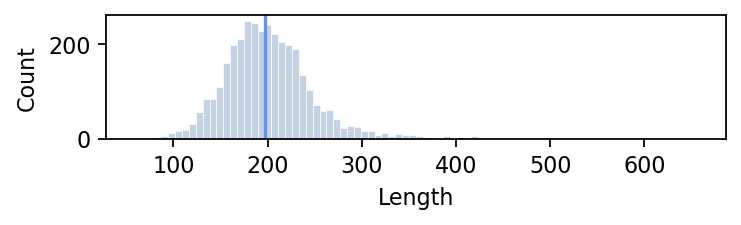

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,1), dpi=160)
sns.histplot(augmented['Length'], color='lightsteelblue', edgecolor='white')
plt.axvline(x=augmented['Length'].median(), color='cornflowerblue', linewidth=1.5)
plt.show()

In [85]:
augmented['Length'] = augmented['Length'].fillna(augmented['Length'].median())
augmented['Length'].isnull().sum()

0

In [86]:
augmented.loc[augmented['Releases'] == 0, 'Releases'] = 1
(augmented['Releases'] == 0).sum()

0

In [88]:
augmented.isnull().sum()

Length      0
Releases    0
Genres      0
ISRC        0
dtype: int64

In [102]:
len(augmented)

4576

Now we can join the augmented and base dataframes on `ISRC`. To do this, we can use an inner or outer join, since every row in augmented is also in base. 

In [103]:
# inner merge augmented and base dataframes
base_augmented = base.merge(augmented, on='ISRC', how='inner')
base_augmented.head()

,ISRC,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track,Length,Releases,Genres
0,QM24S2402528,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,1,725.4,"390,470,936","30,716","196,631,588",...,114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,155.1510,1,[]
1,USUG12400910,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,2,545.9,"323,703,884","28,113","174,597,137",...,111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1,274.1920,5,"['hip hop', 'producer tag - dj mustard']"
2,QZJ842400387,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,3,538.4,"601,309,283","54,331","211,607,669",...,172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0,143.1865,8,['synth-pop']
3,USSM12209777,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,4,444.9,"2,031,280,633","269,802","136,569,078",...,210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0,200.4530,30,"['yacht rock', 'alternative pop', 'pop rock', ..."
4,USUG12403398,Houdini,Houdini,Eminem,5/31/2024,5,423.3,"107,034,922","7,223","151,469,874",...,105.0,"4,493,884","7,006","207,179","457,017",NaN,1,227.0320,20,[]


### Extracting country data from ISRCs

The first two letters of each ISRC encodes the country where the song was registered. It is true that many songs registered in the US are not actually made by people in the United States, so these are only approximations of the country of origin. Ideally the country of origin would be extracted by an API. I have not yet found one that is suitable.

**Adds feature:** Registration Country

In [106]:
base_augmented['ISRC'].head()

0    QM24S2402528
1    USUG12400910
2    QZJ842400387
3    USSM12209777
4    USUG12403398
Name: ISRC, dtype: object

The first two letters of each `ISRC` can be translated according to this document: https://isrc.ifpi.org/downloads/Valid_Characters.pdf

I have converted this PDF to a CSV located at `data/isrc.csv`, and I will use that to translate each `ISRC`.

In [109]:
isrc_translations = pd.read_csv('../data/isrc.csv', skiprows=[1])
isrc_translations.head()

,ISRC Agency Code Allocations - December 2024,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,AD,International ISRC Registration Authority,Andorra,NaN
1,AE,International ISRC Registration Authority,United Arab Emirates,NaN
2,AF,International ISRC Registration Authority,Afghanistan,NaN
3,AG,International ISRC Registration Authority,Antigua and Barbuda,NaN
4,AI,International ISRC Registration Authority,Anguilla,NaN


We are only interested in column 1 and 3. We can drop the rest and rename column 1 and 3.

In [110]:
isrc_translations = isrc_translations.iloc[:, [0, 2]]
isrc_translations.columns = ['Code', 'Country']
isrc_translations.head()

,Code,Country
0,AD,Andorra
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Antigua and Barbuda
4,AI,Anguilla


Now we can use the translations to create a new `Registration Country` column in our main dataset.

In [121]:
# replace 'Worldwide' with 'United States' for visualization purposes
isrc_translations['Country'] = isrc_translations['Country'].replace('Worldwide', 'United States')
isrc_translations['Country'] = isrc_translations['Country'].replace('-', 'United States')

isrc_mapping = dict(zip(isrc_translations['Code'], isrc_translations['Country']))

def map_isrc_to_country(isrc_code):
    """Translates ISRC country code to country name."""
    prefix = isrc_code[:2]
    return isrc_mapping.get(prefix, 'Unknown')

base_augmented['Registration Country'] = base_augmented['ISRC'].apply(map_isrc_to_country)

In [127]:
base_augmented['Registration Country'].unique()

array(['United States', 'Netherlands', 'Russian Federation', 'Brazil',
       'South Korea', 'United Kingdom', 'Nigeria', 'Estonia', 'Romania',
       'Uruguay', 'Mexico', 'Germany', 'Japan', 'Singapore', 'Canada',
       'India', 'Austria', 'Chile', 'France', 'Ireland', 'Sweden',
       'Spain', 'Switzerland', 'United Arab Emirates', 'Turkey',
       'Belgium', 'Cyprus', 'Australia', 'Italy', 'Argentina',
       'South Africa', 'Norway', 'Thailand', 'Colombia', 'New Zealand',
       'Gambia', 'Lebanon', 'Paraguay', 'Philippines', 'Poland',
       'Portugal', 'Indonesia', 'Pakistan', 'Peru', 'Finland',
       'Hong Kong SAR, China', 'Egypt', 'Unknown', 'Viet Nam', 'Ukraine'],
      dtype=object)

Now lets save our augmented dataset to a CSV file.

In [128]:
base_augmented.to_csv('../data/base_v1.csv', index=False, encoding='utf-8')

## Cleaning: Cleaning Primary Dataset

In [129]:
base_v1 = pd.read_csv('../data/base_v1.csv')
base_v1.head()

,ISRC,Track,Album Name,Artist,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track,Length,Releases,Genres,Registration Country
0,QM24S2402528,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,1,725.4,"390,470,936","30,716","196,631,588",...,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,155.1510,1,[],United States
1,USUG12400910,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,2,545.9,"323,703,884","28,113","174,597,137",...,"7,780,028","28,444","6,623,075","1,118,279",NaN,1,274.1920,5,"['hip hop', 'producer tag - dj mustard']",United States
2,QZJ842400387,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,3,538.4,"601,309,283","54,331","211,607,669",...,"5,022,621","5,639","7,208,651","5,285,340",NaN,0,143.1865,8,['synth-pop'],United States
3,USSM12209777,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,4,444.9,"2,031,280,633","269,802","136,569,078",...,"190,260,277","203,384",NaN,"11,822,942",NaN,0,200.4530,30,"['yacht rock', 'alternative pop', 'pop rock', ...",United States
4,USUG12403398,Houdini,Houdini,Eminem,5/31/2024,5,423.3,"107,034,922","7,223","151,469,874",...,"4,493,884","7,006","207,179","457,017",NaN,1,227.0320,20,[],United States


### Handling missing values

### Creating target variable

In [ ]:
import pandas as pd
import numpy as np

# Example dataset with 'Spotify Playlist Count' column
df = pd.DataFrame({
    'Spotify Playlist Count': [10, 50, 200, 75, 30]
})

# Step 1: Calculate the proportion
max_playlist_count = df['Spotify Playlist Count'].max()
df['Playlist Proportion'] = df['Spotify Playlist Count'] / max_playlist_count

# Step 2: Bin the proportions
bins = [0, 0.33, 0.66, 1.0]
labels = ['Low', 'Medium', 'High']
df['Playlist Likelihood'] = pd.cut(df['Playlist Proportion'], bins=bins, labels=labels)

print(df)
